# 3.6 softmax回归的从零开始实现

In [3]:
import torch
import torchvision
import numpy as np
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch
import d2lzh_pytorch as d2l

print(torch.__version__)
print(torchvision.__version__)

1.2.0
0.4.0


## 3.6.1 获取和读取数据

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

Using downloaded and verified file: C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz
Extracting C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw
Using downloaded and verified file: C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz
Extracting C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw
Using downloaded and verified file: C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz
Extracting C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw



0it [00:00, ?it/s]
  0%|                                                                          | 0/5148 [00:01<?, ?it/s]
8192it [00:01, 5665.81it/s]                                                                             

Extracting C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\DeepLearning\msys64\home\Chevady/Datasets/FashionMNIST\FashionMNIST\raw
Processing...
Done!


## 3.6.2 初始化模型参数

In [5]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

In [6]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [7]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


## 3.6.3 实现softmax运算

In [8]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [9]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1542, 0.1947, 0.1424, 0.3368, 0.1720],
        [0.1449, 0.1743, 0.1511, 0.3014, 0.2283]]) tensor([1., 1.])


## 3.6.4 定义模型

In [10]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

## 3.6.5 定义损失函数

In [11]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [12]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

## 3.6.6 计算分类准确率

In [13]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [14]:
print(accuracy(y_hat, y))

0.5


In [15]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [16]:
print(evaluate_accuracy(test_iter, net))

0.069


## 3.6.7 训练模型

In [17]:
num_epochs, lr = 5, 0.1

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7849, train acc 0.751, test acc 0.791
epoch 2, loss 0.5705, train acc 0.814, test acc 0.807
epoch 3, loss 0.5251, train acc 0.825, test acc 0.820
epoch 4, loss 0.5014, train acc 0.832, test acc 0.823
epoch 5, loss 0.4857, train acc 0.836, test acc 0.826


## 3.6.8 预测

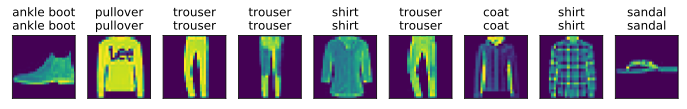

In [18]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])